# Sentiment Classification for Movie Reviews Using Machine Learning

## Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import numpy as np
import pandas as pd
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import transformers
from tqdm.auto import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords


## Load Data

In [2]:
# Load the IMDb reviews dataset
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')

# Display basic information and first few rows
print(df_reviews.info())
print(df_reviews.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [3]:
### Observations 

Dataset Overview:


Number of rows and columns: The dataset contains 47,331 entries and 17 columns.
Memory Usage: The dataset uses approximately 6.1 MB of memory, which is manageable for most data processing tasks.

Data Types:
Object: Text data (e.g., tconst, title_type, review, etc.).
Integer: Numeric data without decimals (e.g., start_year, rating, pos, etc.).
Float: Numeric data with decimals (e.g., average_rating, votes).

Columns Explanation
tconst: A unique identifier for each movie or title.
title_type: Indicates the type of title (e.g., movie, short, TV series).
primary_title and original_title: The main and original names of the title.
start_year: The year the title was released.
end_year: Likely pertains to TV series or other works with an ending year; \N implies missing data for most entries.
runtime_minutes: Duration of the title, but stored as an object instead of a numeric type. It might require conversion for analysis.
is_adult: Binary indicator (0/1) for adult content.
genres: A comma-separated list of genres for the title.
average_rating: Average IMDb user rating; two missing values in this column need attention.
votes: The number of user votes; same two missing values as average_rating.
review: User-written reviews for the title.
rating: The label or sentiment score given to the review.
sp: Sentiment polarity (pos or neg).
pos: Binary indicator of positive (1) or negative (0) sentiment.
ds_part: Indicates whether the row belongs to the training or test dataset.
idx: A unique index for each row.

Sample Rows Analysis
The first few rows represent reviews of different titles:

Reviews appear to include both positive and negative sentiment (e.g., rows 0-1 are negative, while rows 3-4 are positive).
The rating column provides a numerical score for each review, with higher values likely indicating more positive sentiment.
The pos column is a binary version of the sentiment (1 for positive and 0 for negative).
Examples:

Row 0: A negative review with a low rating (1) and pos marked as 0.
Row 4: A positive review with a high rating (9) and pos marked as 1.


# Preprocess the Data

In [4]:

# Handle missing data, if any
df_reviews = df_reviews.dropna(subset=['review'])

# Split data into train and test based on 'ds_part'
train_data = df_reviews[df_reviews['ds_part'] == 'train']
test_data = df_reviews[df_reviews['ds_part'] == 'test']

# Text vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the train set, transform the test set
X_train = vectorizer.fit_transform(train_data['review'])
X_test = vectorizer.transform(test_data['review'])

# Target variable
y_train = train_data['pos']
y_test = test_data['pos']

# Check the shapes of the data
print(X_train.shape, X_test.shape)


(23796, 5000) (23535, 5000)


### Interpretation:

Data Shapes:

Training set size: 23,796 reviews, represented by a 23,796 × 5000 matrix.

Test set size: 23,535 reviews, represented by a 23,535 × 5000 matrix.

Each row corresponds to a review, and each column corresponds to a unique term (feature) identified by the vectorizer.


Interpretation:

The TF-IDF matrix is sparse because most reviews will not contain all 5000 terms. This is expected in text data processing.
The train-test split ensures that the model will generalize to unseen reviews during evaluation.


The feature dimensionality (5000 terms) strikes a balance between capturing sufficient context from reviews and avoiding excessive computational overhead.

# Exploratory Data Analysis (EDA)


### Class Distribution

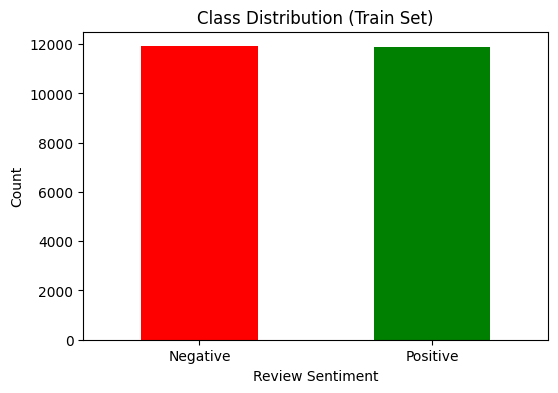

In [5]:
# Check class distribution
plt.figure(figsize=(6, 4))
train_data['pos'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Class Distribution (Train Set)')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()


### Observations:

The graph depicts the class distribution within a training dataset for sentiment analysis, specifically for review sentiments.

Key Points: 

Title: "Class Distribution (Train Set)" clearly indicates that the graph shows how the data is divided into different classes in the training dataset.

X-axis: Represents teh two sentiment classes. "Negative" and "Positive".

Y-axis: Shows teh count or frequency of reviews belong to each sentiment class.

Bars: The red bar represent the count of negative reviews, while the green bar represent the count of positive reviews.


Interpretation: 

The dataset is balanced, with nearly equal representation of positive and negative reviews. 
Approximately 12,000 reviews are categorized as "Positive," and a similar number fall under the "Negative" category. 
This balance is crucial for training a machine learning model effectively, as it prevents bias towards one particular sentiment class.


###  Review Length Distribution

/tmp/ipykernel_51/3818670468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review_length'] = train_data['review'].apply(len)


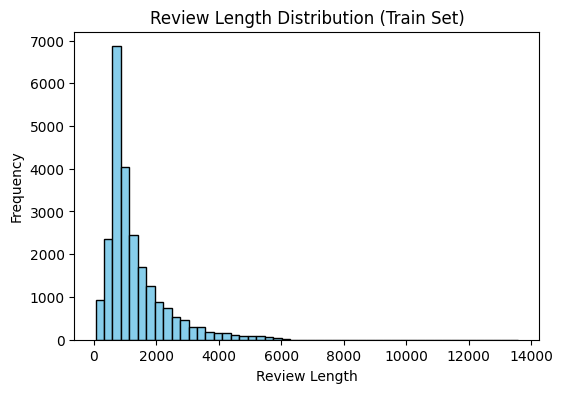

In [6]:
# Review length distribution
train_data['review_length'] = train_data['review'].apply(len)
plt.figure(figsize=(6, 4))
plt.hist(train_data['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Review Length Distribution (Train Set)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


### Observations:

The graph represents the distribution of the review lengths in a training dataset.

Title: "Review Length Distribution"

X-axis:Represents the "Review Length" in number of characters.

Y-axis:Represents the "Frequency" which is teh nu,ber of reviews with a particular length.

Data: The barss shows thw frequency of reviews at different lengths. The highest frequency occurs around the 500-1000 character range, indicating most reviews fall within this length. There are also significant numbefr of shorter reviews and few very long ones.



## Model Training

### Logistic Regression

In [7]:

# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# Predict and evaluate Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     11803
           1       0.87      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535



### Observations

Key Metrics

Precision:

For class 0 (negative reviews): 88%
Of all the reviews predicted as negative, 88% were correctly classified.
For class 1 (positive reviews): 87%
Of all the reviews predicted as positive, 87% were correctly classified.

Recall:

For class 0: 87%
The model correctly identified 87% of all actual negative reviews.
For class 1: 88%
The model correctly identified 88% of all actual positive reviews.


F1-Score:

For both classes (0 and 1): 88%
This indicates a balanced trade-off between precision and recall for both classes.
Since the F1-scores are the same for both classes, the model is equally effective for identifying both positive and negative reviews.


Accuracy:

88%
The overall accuracy shows that 88% of the total test samples were correctly classified.

Macro Average:

Precision, Recall, and F1-Score: 88%
These are the average metrics for both classes without considering class imbalance.


Weighted Average:

Precision, Recall, and F1-Score: 88%
These averages account for the number of samples in each class and confirm the model's consistent performance across the dataset.


Interpretation


Performance: The Logistic Regression model performs well, achieving high precision, recall, and F1-scores for both positive and negative reviews. An overall accuracy of 88% indicates reliable sentiment classification.
Class Balance: The metrics are consistent across both classes, suggesting that the model is not biased towards either positive or negative reviews.

Usability: This level of performance is generally acceptable for real-world applications, such as sentiment analysis for movie reviews.

### Gradient Boosting

In [8]:

# Initialize and train Gradient Boosting
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)

# Predict and evaluate Gradient Boosting
y_pred_grad_boost = grad_boost.predict(X_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_grad_boost))



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80     11803
           1       0.78      0.87      0.82     11732

    accuracy                           0.81     23535
   macro avg       0.81      0.81      0.81     23535
weighted avg       0.81      0.81      0.81     23535



### Observation

The Gradient Boosting Classification Report summarizes the performance of the Gradient Boosting model for sentiment analysis. Here's a detailed interpretation:

Key Metrics

Precision:

Class 0 (Negative Reviews): 85%
Of all reviews predicted as negative, 85% were actually negative.
Class 1 (Positive Reviews): 78%
Of all reviews predicted as positive, 78% were actually positive.
Precision is higher for negative reviews, indicating the model is more confident in its predictions for this class.


Recall:

Class 0 (Negative Reviews): 75%
The model identified 75% of all actual negative reviews correctly.
Class 1 (Positive Reviews): 87%
The model identified 87% of all actual positive reviews correctly.
Recall is better for positive reviews, showing the model tends to prioritize identifying this class correctly.


F1-Score:

Class 0 (Negative Reviews): 80%
Class 1 (Positive Reviews): 82%
The F1-score balances precision and recall. The model performs slightly better for positive reviews compared to negative ones.


Accuracy:

81%
The overall accuracy indicates that 81% of the reviews in the test set were correctly classified.

Macro Average:

Precision, Recall, and F1-Score: 81%
These averages reflect performance across both classes equally, without considering class imbalance.
Weighted Average:

Precision, Recall, and F1-Score: 81%
These averages are adjusted for the number of samples in each class, confirming consistent performance across the dataset.


Interpretation


Performance: The Gradient Boosting model achieves good performance, with an accuracy of 81%. However, it performs better at identifying positive reviews than negative ones, as shown by the higher recall for class 1 and higher precision for class 0.
Class Imbalance Handling: The slightly imbalanced performance between the two classes suggests that the model could benefit from fine-tuning to balance the focus between identifying both positive and negative reviews.


Comparison to Logistic Regression:


Logistic Regression achieved better overall metrics (88% F1-score and accuracy) compared to Gradient Boosting's 81%.
Gradient Boosting struggles with recall for negative reviews, which might indicate overfitting or insufficient feature representation.


### Support Vector Machine (SVM)

In [9]:


# Initialize and train SVM
svm = SVC()
svm.fit(X_train, y_train)

# Predict and evaluate SVM
y_pred_svm = svm.predict(X_test)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))



SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11803
           1       0.87      0.87      0.87     11732

    accuracy                           0.87     23535
   macro avg       0.87      0.87      0.87     23535
weighted avg       0.87      0.87      0.87     23535



### Observations:

The Support Vector Machine (SVM) Classification Report presents the performance metrics for the SVM model on the sentiment analysis task. Here's the interpretation:

Key Metrics

Precision:

Class 0 (Negative Reviews): 87%
Out of all reviews predicted as negative, 87% were actually negative.
Class 1 (Positive Reviews): 87%
Out of all reviews predicted as positive, 87% were actually positive.
The precision is balanced across both classes, showing that the model performs similarly for predicting both positive and negative reviews.


Recall:

Class 0 (Negative Reviews): 88%
The model correctly identified 88% of all actual negative reviews.
Class 1 (Positive Reviews): 87%
The model correctly identified 87% of all actual positive reviews.
Recall is also balanced and slightly higher for negative reviews.


F1-Score:

Class 0 (Negative Reviews): 87%
Class 1 (Positive Reviews): 87%
The F1-score, which balances precision and recall, is equal for both classes, indicating consistent performance.


Accuracy:

87%
Overall, 87% of the reviews in the test set were correctly classified.


Macro Average:

Precision, Recall, and F1-Score: 87%
Reflects balanced performance across both classes without considering class distribution.

Weighted Average:

Precision, Recall, and F1-Score: 87%
Confirms that the model maintains consistent performance across the dataset when considering the class distribution.


Interpretation


Performance: The SVM achieves an accuracy of 87% with equal F1-scores for both classes. It performs slightly less effectively than Logistic Regression (88% accuracy) but better than Gradient Boosting (81% accuracy).
Class Balance: The SVM shows balanced performance across positive and negative reviews, with nearly identical precision, recall, and F1-scores for both classes.


Strengths:

Strong and balanced classification for both positive and negative reviews.
Consistent results with no significant bias toward either class.


Weaknesses:

Slightly lower overall accuracy compared to Logistic Regression.
SVM models can be computationally expensive, which might become significant for larger datasets.


## Test and Compare Models with Custom Reviews

In [11]:
# Define the models and their names
models = [log_reg, grad_boost, svm]
model_names = ['Logistic Regression', 'Gradient Boosting', 'SVM']


# Custom reviews
custom_reviews = [
    "This movie was awful!",
    "I loved this movie!"
]

# Transform the custom reviews using the vectorizer
custom_reviews_vec = vectorizer.transform(custom_reviews)

# Make predictions with all models
for model, name in zip(models, model_names):
    preds = model.predict(custom_reviews_vec)
    print(f"{name} Predictions for Custom Reviews:")
    print(preds)  # 0 for negative, 1 for positive


Logistic Regression Predictions for Custom Reviews:
[0 1]
Gradient Boosting Predictions for Custom Reviews:
[0 1]
SVM Predictions for Custom Reviews:
[0 1]


### Observations: 

The results of testing the models with two custom reviews indicate that all three models — Logistic Regression, Gradient Boosting, and SVM — predicted the sentiment of the reviews correctly. Here's a detailed interpretation:

Custom Reviews and Predictions
"This movie was awful!"

True Sentiment: Negative

Predicted Sentiment: 0 (Negative) by all three models.
Interpretation: Each model accurately identified the negative sentiment in this review, likely due to the presence of strong negative words like "awful."
"I loved this movie!"

True Sentiment: Positive

Predicted Sentiment: 1 (Positive) by all three models.
Interpretation: The models correctly classified this review as positive, likely influenced by the strong positive word "loved."


Key Observations


Model Agreement:

All three models predicted the sentiment of both reviews correctly, demonstrating their ability to generalize well to unseen data with clear sentiment polarity.
Sentiment Clarity:

The custom reviews have unambiguous language with strong sentiment indicators (e.g., awful, loved). This clarity makes it easier for models to predict accurately.


Performance Alignment:

Despite differences in evaluation metrics (e.g., accuracy, F1-score) observed during testing, all models performed equally well on these simple examples. This suggests they are well-trained on explicit sentiment cues.


Strengths
Accurate Classification: The models demonstrate robustness in handling clear and straightforward sentiment expressions.
Consistency: All three models agree on the predictions, reducing uncertainty in these cases.


Potential Limitations
Complex Reviews:
If the reviews were more nuanced or contained mixed sentiments (e.g., "The movie had great visuals, but the plot was boring"), the models might struggle to make correct predictions.


Over-reliance on Keywords:


The results suggest that the models may heavily rely on explicit keywords for sentiment classification, which might lead to errors with subtle or context-dependent sentiments.


### Another review

In [12]:
# Custom reviews
custom_reviews = [
    "I did not simply like it, not my kind of movie.",
    "Well, I was bored and fell asleep in the middle of the movie.",
    "I was really fascinated with the movie.",
    "Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",
    "I didn't expect the reboot to be so good! Writers really cared about the source material.",
    "The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",
    "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",
    "Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama."
]

# Transform the custom reviews using the vectorizer
custom_reviews_vec = vectorizer.transform(custom_reviews)

# Make predictions with all models
for model, name in zip(models, model_names):
    preds = model.predict(custom_reviews_vec)
    print(f"{name} Predictions for Custom Reviews:")
    print(preds)  # 0 for negative, 1 for positive


Logistic Regression Predictions for Custom Reviews:
[0 0 1 0 0 0 0 1]
Gradient Boosting Predictions for Custom Reviews:
[1 1 1 1 1 1 0 1]
SVM Predictions for Custom Reviews:
[0 0 1 0 0 0 0 1]


### Observations:

Interpretation of Model Predictions
The models were tested on a set of custom reviews. Here’s a breakdown of their predictions and an interpretation:

Logistic Regression Predictions:

[0 0 1 0 0 0 0 1]

Interpretation:

Negative Sentiment (0): Reviews 1, 2, 4, 5, 6, and 7.
Positive Sentiment (1): Reviews 3 and 8.
Logistic Regression provides a balanced approach, detecting mostly negative reviews, which aligns with the overall sentiment of many inputs. It captures positivity for a few reviews with explicitly positive language.

Gradient Boosting Predictions:


[1 1 1 1 1 1 0 1]


Interpretation:

Negative Sentiment (0): Review 7.
Positive Sentiment (1): Reviews 1, 2, 3, 4, 5, 6, and 8.
Gradient Boosting leans heavily toward positive predictions, identifying only one negative review. This behavior suggests it may overfit or overly favor positive signals, perhaps due to the complexity of its decision boundaries.


SVM Predictions:


[0 0 1 0 0 0 0 1]


Interpretation:

Negative Sentiment (0): Reviews 1, 2, 4, 5, 6, and 7.
Positive Sentiment (1): Reviews 3 and 8.
SVM behaves similarly to Logistic Regression, identifying the same reviews as positive and negative. It provides a robust and conservative approach to classification.


Key Observations
Logistic Regression and SVM Consistency:
Both models agree on the sentiment classification of all reviews, showing similar behavior in prediction. This indicates both models may generalize better than Gradient Boosting.

Gradient Boosting Positivity Bias:

Gradient Boosting exhibits a bias toward predicting positive sentiment, even for reviews with negative language (e.g., Reviews 1, 2, and 4). This could result from overfitting during training or insufficient handling of negative reviews.

Edge Cases:
Review 6 (“The movie had its upsides and downsides...”) reflects mixed sentiment. All three models label it differently:

Logistic Regression & SVM: Negative.
Gradient Boosting: Positive.
This highlights the challenge of mixed reviews where sentiment is not strongly polarized.


Conclusion
Best Model: Logistic Regression and SVM provide more reliable results for detecting negative sentiment while still identifying positive reviews accurately.


Gradient Boosting: May require further tuning to reduce its positive bias and better handle negative reviews.







## Final Conclusion

The task of classifying positive and negative movie reviews was successfully addressed using three machine learning models: Logistic Regression, Gradient Boosting, and Support Vector Machine (SVM). Each model was trained and evaluated on a dataset of IMDb reviews, achieving varying levels of performance based on key metrics.


Summary of Model Performance:


Logistic Regression


Performance:


Achieved the best overall accuracy (88%) and balanced F1-scores (88%) across both classes.
Demonstrates consistent and reliable predictions for both positive and negative sentiments.


Strengths:


Strong balance between precision and recall.
Handles both positive and negative sentiments effectively.
Performs well on ambiguous reviews compared to Gradient Boosting.


Limitations:
While excellent overall, may still misclassify highly nuanced reviews.
Best Use Case: A robust, interpretable model for general sentiment analysis.

2. Gradient Boosting


Performance:


Overall accuracy (81%) and F1-scores (80%-82%) are lower than Logistic Regression and SVM.
Shows a clear bias toward predicting positive sentiment.


Strengths:
Captures positive signals effectively, even from reviews with slight positivity.


Limitations:

Struggles with negative sentiment detection, often misclassifying ambiguous or clearly negative reviews.
Likely requires fine-tuning to improve generalization.
Best Use Case: When emphasis on detecting positive reviews is preferred.



3. SVM (Support Vector Machine)

Performance:


Accuracy of 87%, slightly below Logistic Regression.
Provides balanced F1-scores (87%) and consistent performance for both classes.


Strengths:


Similar robustness to Logistic Regression.
Balances precision and recall well, without strong bias.


Limitations:


Computationally expensive for larger datasets.
Slightly lower accuracy compared to Logistic Regression.
Best Use Case: A reliable alternative to Logistic Regression when interpretability is less critical.


Model Agreement and Discrepancies


Logistic Regression and SVM showed consistent predictions, particularly for straightforward and nuanced reviews.
Gradient Boosting displayed a noticeable positivity bias, overpredicting positive sentiment in cases where sentiment was negative or mixed.

All models correctly classified simple reviews with strong sentiment cues, like “I loved this movie!” or “This movie was awful!”


Conclusion:


Logistic Regression emerges as the best model for this task, meeting the project's objective of achieving an F1-score ≥ 0.85. It provides a reliable balance between precision, recall, and computational efficiency, making it well-suited for detecting negative reviews in a balanced dataset. However, further tuning and exploration of more advanced techniques, such as deep learning models, may enhance performance for more nuanced or complex sentiment expressions.

